# Prepare Dataset: Compute Stats and Normalize
> Compute dataset statistics, normalize and clean raw datasets and save them as new `.npy` pickle files

**For lab 2 dataset** (raw dataset is in `./data/PJM_Load_hourly.csv`)
1. Compute dataset stats and write it to `./data_stats.csv`.
    - Read/import it as `pd.read_csv('./data_stats.csv',header=0,index_col=0)`
1. Normalize raw dataset with given mean/median and scale.
    - For lab2 in autocaffe we use data stat-s after interpolation.
1. Save normalized datasets as `./train_norm.npy` and `./test_norm.npy`
    - You can later load them with numpy, e.g.
    ```python
    with open('train_norm.npy', 'rb') as f:
        train_norm = np.load(f)
    ```
1. Obtain persistence loss (for normalized data with MSE loss)
    - note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
    - save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
    - You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
# matplotlib.rcParams['font.size']= 22 # use for presentation
pd.options.mode.chained_assignment = None

# read the data
df = pd.read_csv('data/PJM_Load_hourly.csv')

# shape and data types of the data
print(df.shape)
print(df.dtypes)

(32896, 2)
Datetime        object
PJM_Load_MW    float64
dtype: object


# Handling Missing data

In [ ]:
# sort by date & time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

# renaming the target variable columns
df.rename(columns={'PJM_Load_MW':'demand_in_MW'}, inplace=True)

# display the first couple of rows
df.head()

,Datetime,demand_in_MW
0,1998-04-01 01:00:00,22259.0
1,1998-04-01 02:00:00,21244.0
2,1998-04-01 03:00:00,20651.0
3,1998-04-01 04:00:00,20421.0
4,1998-04-01 05:00:00,20713.0


In [ ]:
# let's see if we have a continuous dataset
df = df.set_index('Datetime')
print(f'df.index.freq is set to: {df.index.freq}')

df.index.freq is set to: None


In [ ]:
date_range = pd.date_range(df.index[0],df.index[-1],freq='H')
print(f'The difference in length between the custom date range and our dataset is {(len(date_range)-len(df))}:')
print(date_range.difference(df.index))

The difference in length between the custom date range and our dataset is 8:
DatetimeIndex(['1998-04-05 03:00:00', '1998-10-25 02:00:00',
               '1999-04-04 03:00:00', '1999-10-31 02:00:00',
               '2000-04-02 03:00:00', '2000-10-29 02:00:00',
               '2001-04-01 03:00:00', '2001-10-28 02:00:00'],
              dtype='datetime64[ns]', freq=None)


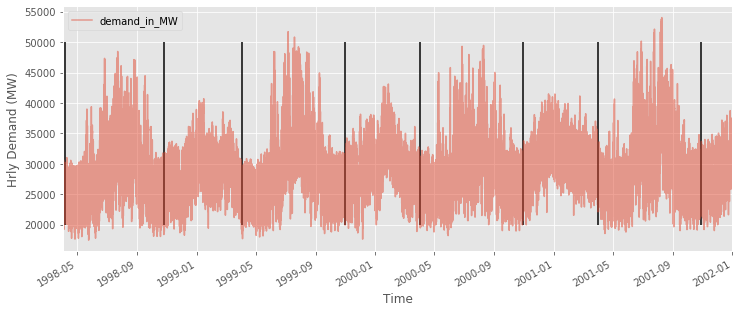

In [ ]:
ax=df.plot(style='-',alpha=.5,figsize=[12,5])
ax.set_ylabel('Hrly Demand (MW)')
ax.set_xlabel('Time')
ax.vlines(date_range.difference(df.index),20000,50000,'k')
plt.show()

In [ ]:
df.head()

,demand_in_MW
Datetime,
1998-04-01 01:00:00,22259.0
1998-04-01 02:00:00,21244.0
1998-04-01 03:00:00,20651.0
1998-04-01 04:00:00,20421.0
1998-04-01 05:00:00,20713.0


Compute stat-s and later write them to `./data_stats.csv`
- raw data before interpolation

In [ ]:
# before interpolation 
data_stats = {}
indx = ['min','max','mean','median','std','range']
data_stats['raw'] = [df.values.min(), df.values.max(),
                       df.values.mean(), np.median(df.values),
                       df.values.std(), df.values.max() - df.values.min() ]

- Interpolate missing values

In [ ]:
print(f'--> # of timeseries samples before interpolation:{len(df)}')
# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['demand_in_MW'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')
print(f'--> # of timeseries samples after interpolation:{len(df)}')

--> # of timeseries samples before interpolation:32896
The df.index.freq is now: <Hour>, indicating that we no longer have missing instances
--> # of timeseries samples after interpolation:32904


- Stat-s after interpolation

In [ ]:
data_stats['after_interp'] = [df.values.min(), df.values.max(),
                              df.values.mean(), np.median(df.values),
                              df.values.std(), df.values.max() - df.values.min() ]

# write to file
data_stats_df  = pd.DataFrame(data=data_stats,index=indx)
data_stats_df.to_csv('./data_stats.csv',
                     header=True,index=True)

print('Dataset statistics:')
data_stats_df

Dataset statistics:


,raw,after_interp
min,17461.000000,17461.000000
max,54030.000000,54030.000000
mean,29766.427408,29766.427408
median,29655.000000,29655.000000
std,5849.681040,5849.681040
range,36569.000000,36569.000000


- For lab2 in autocaffe we use data stat-s _after_ interpolation

## Normalize and Split Dataset

1. Normalize dataset using stats after intepolating missing data points.
1. Split normalized dataset into training and testing datasets:
    - _In autocaffe_ , 70/30 split for lab2 loses the last data point in the raw data. This is most likely due to rounding errors.
    - Here we use the 1st 70% as training data, and the remaining examples as test data. (w/o losing any examples)
1. To normalize all values we use, $mean\approx$29764.0 and 2xS.D. = 11701.6:
$$x_{normalized} = \frac{x_{raw}-29764.0}{11701.6}$$
1. Save normalized datasets into `./train_norm.npy` and `./test_norm.npy`

### Normalize the Interpolated Data

In [ ]:
data_norm = (df.values - 29764.0)/11701.6

### Split into Train/Test

In [ ]:
split_index = data_norm.shape[0]*70//100
train_norm = data_norm[:split_index]
test_norm = data_norm[split_index:]
print(f'data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]: {data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]}')

data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]: True


#### Plot Test/Train

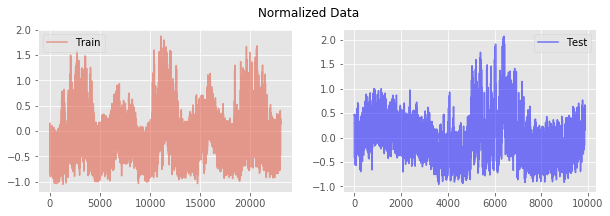

In [ ]:
# For presentation:
# with plt.rc_context({'font.size': 22}):
#     _,axs = plt.subplots(ncols=2,nrows=1,figsize=[20,5])
#     axs[0].plot(train_norm,label='Train',alpha=.5)
#     axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
#     for k in range(axs.shape[0]):
#         axs[k].legend()
#     plt.suptitle('Normalized Data');
_,axs = plt.subplots(ncols=2,nrows=1,figsize=[10,3])
axs[0].plot(train_norm,label='Train',alpha=.5)
axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
for k in range(axs.shape[0]):
    axs[k].legend()
plt.suptitle('Normalized Data');

#### Histograms:

In [ ]:
# Number of bins:
N_bins = 50
# histogram range:
x_range = [min([train_norm.min(),test_norm.min()]),
           max([train_norm.max(),test_norm.max()])]
hist_bins = np.linspace(x_range[0],x_range[1],N_bins)

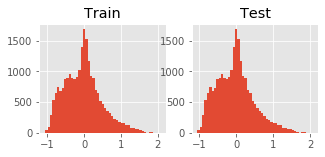

In [ ]:
# # For presentation:
# with plt.rc_context({'font.size': 22}):
#     _, axs = plt.subplots(nrows=1,ncols=2,figsize=[15,5],sharex=True,squeeze=True)
#     # Train
#     axs[0].hist(train_norm, bins=hist_bins)
#     axs[0].set_title('Train')
#     # Test
#     axs[1].hist(test_norm, bins=hist_bins)
#     axs[1].set_title('Test')
#     plt.show()
_, axs = plt.subplots(nrows=1,ncols=2,figsize=[5,2],sharex=True,squeeze=True)
# Train
axs[0].hist(train_norm, bins=hist_bins)
axs[0].set_title('Train')
# Test
axs[1].hist(train_norm, bins=hist_bins)
axs[1].set_title('Test')
plt.show()

---
Difference $Y(T+1)-Y(T+0)$ for normalized data:

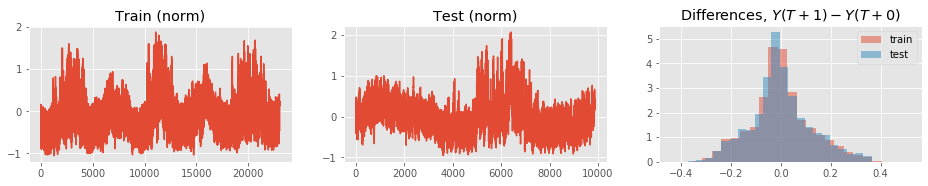

In [ ]:
_,axs = plt.subplots(ncols=3,nrows=1,figsize=[16,2.5],squeeze=True)
# Plot time series
axs[0].plot(train_norm)
axs[0].set_title('Train (norm)')
axs[1].plot(test_norm)
axs[1].set_title('Test (norm)')
# deltaY: differences Y(t+1)-Y(t)
axs[2].hist((train_norm[1:]-train_norm[:-1]),bins=25,density=True,alpha=.5,label='train')
axs[2].hist(test_norm[1:]-test_norm[:-1],bins=25,density=True,alpha=.5,label='test')
plt.title('Differences, $Y(T+1)-Y(T+0)$')
plt.legend()
plt.show()

---

- What do we know about the dataset, e.g. how is it generated? any regularities?
- Note the sharp peak near zero for Y difference data

---

### Write Normalized Datasets to New Files

- Write arrays to `./train_norm.npy` and `./test_norm.npy`

In [ ]:
# normalized training dataset:
with open('train_norm.npy', 'wb') as f:
    np.save(f, train_norm)

# normalized test dataset:
with open('test_norm.npy', 'wb') as f:
    np.save(f, test_norm)
    
# # For loading them back use:
# # with open('train_norm.npy', 'rb') as f:
# #    x_test = np.load(f)

## Persistence Loss (for Normalized Data with MSE loss)

- note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
---
Compute persistence loss and save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
- You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.
- Here, `persistence` is computed starting from the first elements of `train_norm` (or `test_norm`). Your exact training/testing dataset will start from the last element in the window, which will be set as first $Y(T+0)$.

In [ ]:
import utils

In [ ]:
Tlead = 5
# utils.persistence_loss by default uses MSE as metric
persistence_data = np.array({'lead_time':Tlead,
                             'persist_train':utils.persistence_loss(train_norm,lead_time=Tlead),
                             'persist_test':utils.persistence_loss(test_norm,lead_time=Tlead)})

with open('persistence_T{}.npy'.format(Tlead), 'wb') as f:
    np.save(f,persistence_data)

print(persistence_data)

{'lead_time': 5, 'persist_train': 0.2327920374234529, 'persist_test': 0.23192373859204968}


In "autocaffe" there's an additional (and unnecessary) 0.5x factor for persistence:

In [ ]:
# persistence_data = persistence_data.item()
print('Autocaffe\'s "persistence" for T+{}\ntrain: {}\ntest{}'.format(
    Tlead,persistence_data.item()['persist_train']/2,persistence_data.item()['persist_test']/2) )

Autocaffe's "persistence" for T+5
train: 0.11639601871172645
test0.11596186929602484
